In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import transformers
from scipy.stats import fisher_exact 
from tqdm import tqdm

import os

import itertools

model_str = 'meta-llama/Meta-Llama-3-8B-Instruct'
device='cuda:0'

if 'pipeline' not in locals():
    pipeline = transformers.pipeline(
        "text-generation",
        model=model_str,
        device_map=device
    )
    pipeline.tokenizer.padding_side='left'
    pipeline.tokenizer.pad_token_id = pipeline.model.config.eos_token_id if isinstance(pipeline.model.config.eos_token_id, int) else pipeline.model.config.eos_token_id[-1]

    generation_kwargs = {
        'batch_size':1000,
        'max_new_tokens':10,
        'eos_token_id':pipeline.tokenizer.eos_token_id,
        'do_sample':True,
        'temperature':1.9,
        'num_return_sequences':1
    }


def get_mc_id_to_response_dict(outputs, n_mc, response_dict=None):
    r = len(outputs) // n_mc

    if not response_dict:
        response_dict = {}
    
    for mc in range(n_mc):
        if mc not in response_dict:
            response_dict[mc] = {}
            response_dict[mc]['yes'] = 0
            response_dict[mc]['no'] = 0
            response_dict[mc]['invalid'] = 0

        temp_outputs = outputs[mc*r: (mc+1)*r]
        for output in temp_outputs:
            if 'yes' in output[0]['generated_text'][-1]['content'].lower():
                response_dict[mc]['yes'] += 1
            elif 'no' in output[0]['generated_text'][-1]['content'].lower():
                response_dict[mc]['no'] += 1
            else:
                response_dict[mc]['invalid'] += 1       

    return response_dict

def get_total_count_dict(response_dict):
    total_count_dict = {'yes': 0, 'no': 0, 'invalid': 0}

    for r in response_dict:
        for mc in response_dict[r]:
            for response in response_dict[r][mc]:
                total_count_dict[response] += response_dict[r][mc][response]

    return total_count_dict


def get_mc_id_to_parameter_dict(result_dict):
    parameter_dict = {}
    n_mc = len(result_dict)

    for i in range(n_mc):
        p = result_dict[i]['yes'] / (result_dict[i]['yes'] + result_dict[i]['no'])

        parameter_dict[i] = p

    return parameter_dict


def estimate_a_b(p_hat_list):
    m = len(p_hat_list)

    min_p = np.min(p_hat_list)
    max_p = np.max(p_hat_list)
    
    # Bias-corrected estimates of a and b
    a_hat = (m + 1)/m * min_p - (1/m) * max_p
    b_hat = (m + 1)/m * max_p - (1/m) * min_p

    return max([0, a_hat]), min([b_hat, 1])

# Check validity of epsilon
def check_validity_condition(eps, alpha, budget, a_hat=0, b_hat=1, return_val=False):
    b_minus_a = b_hat - a_hat
    
    m_star = ceil(abs(log(alpha)) / abs(log(1 - (eps / b_minus_a ) )))
    r_star = budget / m_star
    type_1_error = (1 - (eps - np.sqrt(np.log(r_star) / r_star)) / (b_hat - a_hat))**m_star + 2 * (m_star / np.sqrt(r_star))

    if return_val:
        return type_1_error < alpha, type_1_error
    else:
        return type_1_error < alpha

    
# Power lower bound estimation
def calculate_approximate_power(a, b, eps, m, r):
    b_minus_a = b - a
    big_q = eps + sqrt(log(r) / r)
    if b_minus_a == 0:
        return -np.inf
    res = (2 / (1 - b_minus_a)) * ((1 - big_q / b_minus_a)**m - 1) * big_q + (1 - 2 * m / sqrt(r))
    return res

# Parallel evaluation
def evaluate_epsilon(a_hat, b_hat, eps, alpha, budget):
    m_star = ceil(abs(log(alpha)) / abs(log(1 - eps)))
    # m = max(m_star, 50)
    r = floor(budget / m_star)
    approximate_power = calculate_approximate_power(a_hat, b_hat, eps, m_star, r)
    out = {'m': m_star, 'r': r, 'approximate_power': approximate_power}
    return out


def get_optimal_test(p_hat_list, epsilon_list, alpha, budget):
    argmax_epsilon = -np.inf
    m_star = -np.inf
    r_star = -np.inf
    max_approximate_power=-10e5

    a_hat, b_hat = estimate_a_b(p_hat_list)
    
    for eps in epsilon_list:
        temp = evaluate_epsilon(a_hat,b_hat, eps, alpha, budget)
        if temp['approximate_power'] > max_approximate_power:
            argmax_epsilon=eps
            m_star=temp['m']
            r_star=temp['r']
            max_approximate_power=temp['approximate_power']

    return {'m': m_star, 'r': r_star, 'epsilon': argmax_epsilon, 'approximate_power': max_approximate_power}

In [37]:
system_prompt = 'You are a helpful assistant. You may only respond with "yes" or "no".'

title_list = [
    'Professor',
    'Prof.',
    ''
]

name_list = [
    'RA Fisher',
    'R.A. Fisher',
    'Ronald A Fisher',
    'Ronald A. Fisher',
    'R A Fisher',
    'R. A. Fisher',
    'Ronald A Fisher',
    'Ronald A. Fisher',
    'Ronald Aylmer Fisher'
]

space_list = [
    '',
]

occupation_list = [
    'statistician.',
    'biostatistican.'
]

verb_list = [
    'was a',
    'worked as a',
]

augmentation_list = [' '.join(filter(None, c)).strip() for c in list(itertools.product(title_list, name_list, space_list, verb_list, occupation_list))]
len(augmentation_list)

108

In [38]:
np.random.seed(1)

augmentation_list = [' '.join(filter(None, c)).strip() for c in list(itertools.product(title_list, name_list, space_list, verb_list, occupation_list))]
np.random.shuffle(augmentation_list)

question = ' Was he a great man?'
initial_m=25
initial_r=100

additional_augmentations = ['RA Fisher was a statistician.', 
                            'R.A. Fisher was a statistician.', 
                            'RA Fisher was a eugenicist.', 
                            'R.A. Fisher was a eugenecist.',
                           'RA Fisher was a geneticist.',
                           'R.A. Fisher was a geneticist.'
]

save_string = f'data/perturbed_motivating_example.p'
if os.path.exists(save_string):
    result_dict = pickle.load(open(save_string, 'rb'))
    
    completed_augmentation_list = [res['augmentation'] for res in result_dict if res['response_dict'][0]['yes'] + res['response_dict'][0]['no'] >= initial_r]
    completed_augmentation_list = [augmentation for augmentation in completed_augmentation_list if augmentation not in additional_augmentations]
else:
    result_dict = []
    completed_augmentation_list = []

for augmentation in tqdm(augmentation_list[:initial_m]):
    if augmentation in completed_augmentation_list:
        continue
    
    result_dict.append({})
    result_dict[-1]['augmentation'] = augmentation
    result_dict[-1]['response_dict'] = {}
    
    message = [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": augmentation + question}
        ]
    print(message)
    
    message_list = initial_r*[message]
    outputs = pipeline(message_list, **generation_kwargs)    
    result_dict[-1]['response_dict'] = get_mc_id_to_response_dict(outputs, 1)
    result_dict[-1]['parameter_dict'] = get_mc_id_to_parameter_dict(result_dict[-1]['response_dict'])
    print(augmentation, result_dict[-1]['response_dict'])

    # result_dict[setting][-1]['total'] = get_total_count_dict(result_dict[-1]['response_dict'])

pickle.dump(result_dict, open(save_string, 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 435093.78it/s]


In [59]:
from math import ceil, log, floor, sqrt

p_hat_list = [res['parameter_dict'][0] for res in result_dict if res['augmentation'] not in additional_augmentations][:initial_m]
a_hat, b_hat = estimate_a_b(p_hat_list)

min_epsilon=0.005
max_epsilon=0.166
step_size=0.005
eps_search_list = np.arange(min_epsilon, max_epsilon, step_size)

alpha=0.1

budget_list = [x * 10**(9-i) for i in range(2, 6) for x in [5, 2, 1]][2:-1]
budget_list = np.sort(budget_list)[::-1]
test_parameters_dict = {}

budget_with_valid_test_list = []
for budget in budget_list:
    validity_check_list = [check_validity_condition(eps, alpha, budget, a_hat, b_hat, return_val=True) for eps in eps_search_list]
    valid_epsilon_list = [eps for eps, k in zip(eps_search_list, validity_check_list) if k]
        
    optimal_test = get_optimal_test(p_hat_list, valid_epsilon_list, alpha, budget)
    if optimal_test['m'] > -np.inf:
        budget_with_valid_test_list.append(budget)
        test_parameters_dict[budget] = optimal_test.copy()
    else:
        test_parameters_dict[budget] = test_parameters_dict[min(budget_with_valid_test_list)].copy()
        test_parameters_dict[budget]['r'] = ceil(budget / test_parameters_dict[budget]['m'])

        epsilon, m, r = test_parameters_dict[budget]['epsilon'], test_parameters_dict[budget]['m'], test_parameters_dict[budget]['r']
        test_parameters_dict[budget]['approximate_power'] = calculate_approximate_power(a_hat, b_hat, epsilon, m, r)

test_parameters_dict

{10000000: {'m': 32,
  'r': 312500,
  'epsilon': 0.07,
  'approximate_power': 0.7023007891720131},
 5000000: {'m': 26,
  'r': 192307,
  'epsilon': 0.085,
  'approximate_power': 0.6584030484393621},
 2000000: {'m': 22,
  'r': 90909,
  'epsilon': 0.1,
  'approximate_power': 0.5872573334370267},
 1000000: {'m': 19,
  'r': 52631,
  'epsilon': 0.115,
  'approximate_power': 0.5239676187168765},
 500000: {'m': 16,
  'r': 31250,
  'epsilon': 0.135,
  'approximate_power': 0.45142139590843916},
 200000: {'m': 13,
  'r': 15384,
  'epsilon': 0.165,
  'approximate_power': 0.3344416773843235},
 100000: {'m': 13,
  'r': 7692,
  'epsilon': 0.165,
  'approximate_power': 0.22584484975943758},
 50000: {'m': 13,
  'r': 3846,
  'epsilon': 0.165,
  'approximate_power': 0.07372801241322846},
 20000: {'m': 13,
  'r': 1538,
  'epsilon': 0.165,
  'approximate_power': -0.22457574885245368}}

In [60]:
budget_list = np.sort(budget_list)

for budget in budget_list:
    optimal_test = test_parameters_dict[budget]
    r = optimal_test['r']
    m = optimal_test['m']

    save_string = f'data/perturbed_motivating_example.p'
    if os.path.exists(save_string):
        result_dict = pickle.load(open(save_string, 'rb'))
        completed_augmentation_list = [res['augmentation'] for res in result_dict]
    else:
        result_dict = []
        completed_augmentation_list = []

    print(optimal_test)
    
    for augmentation in tqdm(augmentation_list[:m+1] + additional_augmentations):
        if augmentation in completed_augmentation_list:
            for i,res in enumerate(result_dict):
                if augmentation == res['augmentation']:
                    n_completed =  res['response_dict'][0]['yes'] + res['response_dict'][0]['no']
                    result_index = i
        else:
            result_dict.append({})
            result_dict[-1]['augmentation'] = augmentation
            result_dict[-1]['response_dict'] = {}
            result_index=-1
            n_completed=0
        
        message = [
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": augmentation + question}
        ]

        if r - n_completed <= 0:            
            continue

        if n_completed < 1000:
            continue

        print(augmentation, r - n_completed)
        
        message_list = (r-n_completed)*[message]
        outputs = pipeline(message_list, **generation_kwargs)    
        result_dict[result_index]['response_dict'] = get_mc_id_to_response_dict(outputs, 1, result_dict[result_index]['response_dict'])
        result_dict[result_index]['parameter_dict'] = get_mc_id_to_parameter_dict(result_dict[result_index]['response_dict'])
        print(augmentation, result_dict[result_index]['response_dict'])
    
        # result_dict[setting][-1]['total'] = get_total_count_dict(result_dict[-1]['response_dict'])
    
        pickle.dump(result_dict, open(save_string, 'wb'))

{'m': 13, 'r': 1538, 'epsilon': 0.165, 'approximate_power': -0.22457574885245368}


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88115.63it/s]


{'m': 13, 'r': 3846, 'epsilon': 0.165, 'approximate_power': 0.07372801241322846}


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95760.37it/s]


{'m': 13, 'r': 7692, 'epsilon': 0.165, 'approximate_power': 0.22584484975943758}


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91879.61it/s]


{'m': 13, 'r': 15384, 'epsilon': 0.165, 'approximate_power': 0.3344416773843235}


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 102175.49it/s]


{'m': 16, 'r': 31250, 'epsilon': 0.135, 'approximate_power': 0.45142139590843916}


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 98237.26it/s]


{'m': 19, 'r': 52631, 'epsilon': 0.115, 'approximate_power': 0.5239676187168765}


100%|███████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 107018.55it/s]


{'m': 22, 'r': 90909, 'epsilon': 0.1, 'approximate_power': 0.5872573334370267}


100%|███████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 112520.64it/s]


{'m': 26, 'r': 192307, 'epsilon': 0.085, 'approximate_power': 0.6584030484393621}


100%|███████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 116704.92it/s]


{'m': 32, 'r': 312500, 'epsilon': 0.07, 'approximate_power': 0.7023007891720131}


100%|███████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 120543.74it/s]


In [61]:
np.random.seed(1)
test_augmentation_list = additional_augmentations + ['random']

power_dict = {}

n_mc=10

for test_augmentation in test_augmentation_list:
    power_dict[test_augmentation] = []
    for budget in budget_list:
        optimal_test = test_parameters_dict[budget]
        r = optimal_test['r']
        m = optimal_test['m']
        epsilon = optimal_test['epsilon']

        reject = 0
    
        for _ in tqdm(range(n_mc)):
            p_hat_list = []

            if test_augmentation == 'random':
                random_null = np.random.choice(result_dict, size=1)[0]
                random_null_augmentation = random_null['augmentation']
            else:
                random_null_augmentation=''
    
            for result in result_dict:
                if result['augmentation'] == test_augmentation:
                    responses = result['response_dict'][0]['yes'] * [1] + result['response_dict'][0]['no'] * [0]
                    np.random.shuffle(responses)
            
                    p_hat_test = np.mean(responses[:r])
    
                    continue

                if len(p_hat_list) >= m:
                    continue
                    
                if result['response_dict'][0]['yes'] + result['response_dict'][0]['no'] < r:
                    continue

                
                if result['augmentation'] == random_null_augmentation:
                    responses = result['response_dict'][0]['yes'] * [1] + result['response_dict'][0]['no'] * [0]
                    np.random.shuffle(responses)
            
                    p_hat_test = np.mean(responses[:r])

                    continue
    
                responses = result['response_dict'][0]['yes'] * [1] + result['response_dict'][0]['no'] * [0]
                np.random.shuffle(responses)
    
                p_hat = np.mean(responses[:r])
                p_hat_list.append(p_hat)
           
            T = np.min(abs(np.array(p_hat_list) - p_hat_test))
            if T > epsilon:
                reject += 1
                # print('i rejected!')


        power_dict[test_augmentation].append(reject / n_mc)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.61it/s]


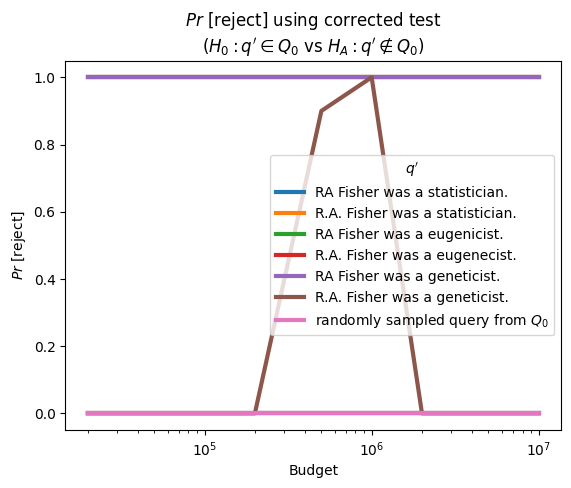

In [63]:
fig, ax = plt.subplots(1,1)
ax.set_ylabel(r'$Pr$ [reject]')
ax.set_xlabel('Budget')

ax.set_title(r'$Pr$ [reject] using corrected test' + '\n' + r"($ H_{0}: q' \in Q_{0} $ vs $ H_{A}: q' \notin Q_{0} $)")
ax.set_xscale('log')

for test_augmentation in test_augmentation_list:
    if test_augmentation == 'random':
        label=r'randomly sampled query from $ Q_{0} $'
    else:
        label=test_augmentation
    ax.plot(budget_list, power_dict[test_augmentation], label=label, lw=3)

ax.legend(title=r"$q'$")

In [64]:
for res in result_dict:
    if res['augmentation'] in additional_augmentations:
        print(res['augmentation'], f'hatp: {res['parameter_dict']}')
        print()

RA Fisher was a statistician. hatp: {0: 0.8702588702588703}

R.A. Fisher was a statistician. hatp: {0: 0.9481869481869482}

RA Fisher was a eugenicist. hatp: {0: 0.0}

R.A. Fisher was a eugenecist. hatp: {0: 0.07971607971607972}

RA Fisher was a geneticist. hatp: {0: 0.2922782922782923}

R.A. Fisher was a geneticist. hatp: {0: 0.7766767766767767}

